In [45]:
import numpy as np
import math
import os
import random
from matplotlib import pyplot as pl
import queue
import collections
import seaborn as sns

In [46]:
PAGE_SIZE = 4096                    # Page Size in Bytes
NP = 6                              # No. of processes in memory
F = 32                              # No. of Frames in physical memory
INVALID = -10
PID = 0                             # Used for Indexing into Frames
FRAME = 1                           # Used for Indexing into Frames
COMPLETED = 10                      # Process Status Flags
INCOMPLETE = 20                     #
# The following are page replacement algorithm types
FIFO_GLOBAL = 10
oldest_frame = 0
recent_frame=0

In [47]:
loc_oldest_frame = np.zeros(F).astype('int32')
algos=["lrul","lrug","fifol","fifog","mrul","mrug","lful","lfug","rrl","rrg"]

page_frequency = {}
page_frequencyg = {}
fifo_old_frames = {}
mru_recent_frames = {}


fifo_l=[]
fifo_g=[]

lru_l=[]
lru_g=[]

mru_l=[]
mru_g=[]

rr_l=[]
rr_g=[]

lfu_l=[]
lfu_g=[]

In [48]:
phys_mem_fifo_l = np.full((F, 2), INVALID).astype('int32')
phys_mem_fifo_g = np.full((F, 2), INVALID).astype('int32')

phys_mem_lru_l = np.full((F, 2), INVALID).astype('int32')
phys_mem_lru_g = np.full((F, 2), INVALID).astype('int32')

phys_mem_rr_l = np.full((F, 2), INVALID).astype('int32')
phys_mem_rr_g = np.full((F, 2), INVALID).astype('int32')

phys_mem_lfu_l = np.full((F, 2), INVALID).astype('int32')
phys_mem_lfu_g = np.full((F, 2), INVALID).astype('int32')

phys_mem_mru_l = np.full((F, 2), INVALID).astype('int32')
phys_mem_mru_g = np.full((F, 2), INVALID).astype('int32')

pr_timing_fifol = np.zeros(F).astype('int32')
pr_timing_fifog = np.zeros(F).astype('int32')
pr_timing_lrul = np.zeros(F).astype('int32')
pr_timing_lrug = np.zeros(F).astype('int32')
pr_timing_rrl = np.zeros(F).astype('int32')
pr_timing_rrg = np.zeros(F).astype('int32')
pr_timing_lful = np.zeros(F).astype('int32')
pr_timing_lfug = np.zeros(F).astype('int32')
pr_timing_mrul = np.zeros(F).astype('int32')
pr_timing_mrug = np.zeros(F).astype('int32')

In [49]:
def init_proc_queue():
    pq = queue.Queue(maxsize=NP)
    proc_queue = list(set((NP * np.random.random(20)).astype('int32')))
    random.shuffle(proc_queue)
    print(proc_queue)
    for pr in proc_queue:
        fifo_old_frames[pr]=0
        mru_recent_frames[pr]=0
        pq.put_nowait(pr)
    return(pq)

def readq(q):
    while True:
        try:
            yield q.get_nowait()
        except queue.Empty:
            break

In [50]:
def init_phys_mem():
    for i in range(F):
        phys_mem_fifo_l[i, PID] = INVALID
        phys_mem_fifo_l[i, FRAME] = INVALID

        phys_mem_fifo_g[i, PID] = INVALID
        phys_mem_fifo_g[i, FRAME] = INVALID

        phys_mem_lru_g[i, PID] = INVALID
        phys_mem_lru_g[i, FRAME] = INVALID

        phys_mem_lru_l[i, PID] = INVALID
        phys_mem_lru_l[i, FRAME] = INVALID
        
        phys_mem_rr_l[i, PID] = INVALID
        phys_mem_rr_l[i, FRAME] = INVALID

        phys_mem_rr_g[i, PID] = INVALID
        phys_mem_rr_g[i, FRAME] = INVALID

        phys_mem_lfu_g[i, PID] = INVALID
        phys_mem_lfu_g[i, FRAME] = INVALID

        phys_mem_lfu_l[i, PID] = INVALID
        phys_mem_lfu_l[i, FRAME] = INVALID

        phys_mem_mru_l[i, PID] = INVALID
        phys_mem_mru_l[i, FRAME] = INVALID

        phys_mem_mru_g[i, PID] = INVALID
        phys_mem_mru_g[i, FRAME] = INVALID



def update_phys_mem(pid):
    for i in range(F):
        
        #         Updating physical memory of FIFO Local
        
        if phys_mem_fifo_l[i, PID] == pid:
            phys_mem_fifo_l[i, PID] = INVALID
            phys_mem_fifo_l[i, FRAME] = INVALID
            
        #         Updating physical memory of FIFO Global
        
        if phys_mem_fifo_g[i, PID] == pid:
            phys_mem_fifo_g[i, PID] = INVALID
            phys_mem_fifo_g[i, FRAME] = INVALID
            
        #         Updating physical memory of LRU Global
        
        if phys_mem_lru_g[i, PID] == pid:
            phys_mem_lru_g[i, PID] = INVALID
            phys_mem_lru_g[i, FRAME] = INVALID
            
        #         Updating physical memory of LRU Local
        
        if phys_mem_lru_l[i, PID] == pid:
            phys_mem_lru_l[i, PID] = INVALID
            phys_mem_lru_l[i, FRAME] = INVALID
    
    
    
        if phys_mem_rr_l[i,PID] == pid:
            phys_mem_rr_l[i, PID] = INVALID
            phys_mem_rr_l[i, FRAME] = INVALID
        
        
        if phys_mem_rr_g[i,PID] == pid:
            phys_mem_rr_g[i, PID] = INVALID
            phys_mem_rr_g[i, FRAME] = INVALID
        
        
        if phys_mem_lfu_g[i,PID] == pid:
            phys_mem_lfu_g[i, PID] = INVALID
            phys_mem_lfu_g[i, FRAME] = INVALID

        
        if phys_mem_lfu_l[i,PID] == pid:
            phys_mem_lfu_l[i, PID] = INVALID
            phys_mem_lfu_l[i, FRAME] = INVALID

            
        if phys_mem_mru_l[i,PID] == pid:
            phys_mem_mru_l[i, PID] = INVALID
            phys_mem_mru_l[i, FRAME] = INVALID

                
        if phys_mem_mru_g[i,PID] == pid:
            phys_mem_mru_g[i, PID] = INVALID
            phys_mem_mru_g[i, FRAME] = INVALID

In [51]:
def correct_refs(alist, cent, maxpg):
    if cent != 0:
        pgnum = int(cent / PAGE_SIZE)
        lh = (pgnum + 1) * PAGE_SIZE - 1
        ll = pgnum * PAGE_SIZE
    else:
        lh = maxpg * PAGE_SIZE
        ll = 0
    for i in range(alist.shape[0]):
        if alist[i] >= lh:
            alist[i] = lh - 1
        if alist[i] < ll:
            alist[i] = ll + 1
    return alist

def sim_process(M, sigma, outfile,pid, lfrac):
    cur_page = int(M * np.random.random())  # Generate a random start page
    cur_locale = round(PAGE_SIZE * (cur_page + 0.5))  # Locality of reference
    sum_refs = 0
    list_locales = list()
    frequencies={}
    for count in range(M):
        
        frequencies[cur_page]=0

        # random page address in memory.
        num_refs = int(512 + (PAGE_SIZE - 512) * np.random.random())
        sum_refs += num_refs
        list_locales.append(cur_page)
        num_loc = round(lfrac * num_refs)
        aref_list = np.random.normal(cur_locale, sigma * 300 + 100,
                                     num_loc)  # If siagma is less, it stays less within that locality of reference
        # if sigma more, it may vary more
        aref_list = correct_refs(aref_list, cur_locale, M)
        aref_list = aref_list.astype('int32')
        cur_page = int(M * np.random.random())
        cur_locale = round(PAGE_SIZE * (cur_page + 0.5))
        num_trans = round((1 - lfrac) * num_refs)
        tref_list = np.random.random(num_trans) * cur_locale
        tref_list = correct_refs(tref_list, 0, M)
        tref_list = tref_list.astype('int32')
        np.append(aref_list, tref_list).tofile(outfile, sep='\n')
        outfile.write('\n')
    page_frequency[pid]=frequencies
    return list_locales, sum_refs

In [52]:
def get_oldest_frameL(pr):
    global oldest_frame
    rv = oldest_frame
    oldest_frame += 1
    if oldest_frame == F:
        oldest_frame = 0
    return rv

def get_oldest_frameG(pr):
    global fifo_old_frames
    rv = fifo_old_frames[pr]
    fifo_old_frames[pr] += 1
    if fifo_old_frames[pr] == F:
        fifo_old_frames[pr] = 0
    return rv


def getFifoFrameL( pnum, pr):
    fr_num=0
    while fr_num < F:
        if phys_mem_fifo_l[fr_num, PID] == pr and phys_mem_fifo_l[fr_num, FRAME] == pnum:
            break
        else:
            fr_num += 1
    return fr_num

def getFifoFrameG( pnum, pr):
    fr_num=0
    while fr_num < F:
        if phys_mem_fifo_g[fr_num, PID] == pr and phys_mem_fifo_g[fr_num, FRAME] == pnum:
            break
        else:
            fr_num += 1
    return fr_num


def getLruFrameL(pnum, pr):
    fr_num=0
    global phys_mem_lru_l
    while fr_num < F:
        if phys_mem_lru_l[fr_num, PID] == pr and phys_mem_lru_l[fr_num, FRAME] == pnum:
            temp = np.array([pr, pnum])
            phys_mem_lru_l = np.delete(phys_mem_lru_l, fr_num, axis=0)
            phys_mem_lru_l = np.concatenate([phys_mem_lru_l, temp.reshape(1, -1)], axis=0)
            break
        else:
            fr_num += 1
    return fr_num

def getLruFrameG( pnum, pr):
    fr_num=0
    global phys_mem_lru_g
    while fr_num < F:
        if phys_mem_lru_g[fr_num, PID] == pr and phys_mem_lru_g[fr_num, FRAME] == pnum:
            temp = np.array([pr, pnum])
            phys_mem_lru_g = np.delete(phys_mem_lru_g, fr_num, axis=0)
            phys_mem_lru_g = np.concatenate([phys_mem_lru_g, temp.reshape(1, -1)], axis=0)
            break
        else:
            fr_num += 1
    return fr_num

def getMRUFrameL(pnum, pr):
    fr_num = 0
    while fr_num < F:
        if phys_mem_mru_l[fr_num, PID] == pr and phys_mem_mru_l[fr_num, FRAME] == pnum:
            mru_recent_frames[pr]=fr_num
            break
        else:
            fr_num += 1
    return fr_num


def getRRFrameL(pnum, pr):
    fr_num = 0
    while fr_num < F:
        if phys_mem_rr_l[fr_num, PID] == pr and phys_mem_rr_l[fr_num, FRAME] == pnum:
            break
        else:
            fr_num += 1
    return fr_num


def getLFUFrameL(pnum, pr):
    global page_frequency
    fr_num = 0
    while fr_num < F:
        if phys_mem_lfu_l[fr_num, PID] == pr and phys_mem_lfu_l[fr_num, FRAME] == pnum:
            if pnum not in page_frequency[pr]:
                page_frequency[pr][pnum]=1
            else:
                page_frequency[pr][pnum]+=1
            break
        else:
            fr_num += 1
    return fr_num

def getMRUFrameG( pnum, pr):
    fr_num = 0
    while fr_num < F:
        if phys_mem_mru_g[fr_num, PID] == pr and phys_mem_mru_g[fr_num, FRAME] == pnum:
            break
        else:
            fr_num += 1
    recent_frame=fr_num
    return fr_num


def getRRFrameG( pnum, pr):
    fr_num = 0
    while fr_num < F:
        if phys_mem_rr_g[fr_num, PID] == pr and phys_mem_rr_g[fr_num, FRAME] == pnum:
            break
        else:
            fr_num += 1
    return fr_num


def getLFUFrameG( pnum, pr):
    fr_num = 0
    while fr_num < F:
        if phys_mem_lfu_g[fr_num, PID] == pr and phys_mem_lfu_g[fr_num, FRAME] == pnum:
            if pnum not in page_frequencyg:
                page_frequencyg[pnum]=1
            else:
                page_frequencyg[pnum]+=1
            break
        else:
            fr_num += 1
    return fr_num

In [53]:
def gen_pagefault(pgnum, pr,algo=None):

    fr_num = 0
    
    if algo=="lrul":
        while fr_num < F and phys_mem_lru_l[fr_num, FRAME] >= 0:
            fr_num += 1
        if fr_num >= F:
            return INVALID
        phys_mem_lru_l[fr_num, FRAME] = pgnum
        phys_mem_lru_l[fr_num, PID] = pr
        return fr_num
    
    elif algo=="lrug":
        while fr_num < F and phys_mem_lru_g[fr_num, FRAME] >= 0:
            fr_num += 1
        if fr_num >= F:
            return INVALID
        phys_mem_lru_g[fr_num, FRAME] = pgnum
        phys_mem_lru_g[fr_num, PID] = pr
        return fr_num
            
    elif algo=="fifol":
        while fr_num < F and phys_mem_fifo_l[fr_num, FRAME] >= 0:
            fr_num += 1
        if fr_num >= F:
            return INVALID
        phys_mem_fifo_l[fr_num, FRAME] = pgnum
        phys_mem_fifo_l[fr_num, PID] = pr
        return fr_num
        
    elif algo == "fifog":
        while fr_num < F and phys_mem_fifo_g[fr_num, FRAME] >= 0:
            fr_num += 1
        if fr_num >= F:
            return INVALID
        phys_mem_fifo_g[fr_num, FRAME] = pgnum
        phys_mem_fifo_g[fr_num, PID] = pr
        return fr_num
        
    elif algo == "lful":
        while fr_num < F and phys_mem_lfu_l[fr_num, FRAME] >= 0:
            fr_num += 1
        if fr_num >= F:
            return INVALID
        phys_mem_lfu_l[fr_num, FRAME] = pgnum
        phys_mem_lfu_l[fr_num, PID] = pr
        if pgnum not in page_frequency[pr]:
            page_frequency[pr][pgnum]=1
        else:
            page_frequency[pr][pgnum]+=1
        return fr_num
    
    elif algo == "rrl":
        while fr_num < F and phys_mem_rr_l[fr_num, FRAME] >= 0:
            fr_num += 1
        if fr_num >= F:
            return INVALID
        phys_mem_rr_l[fr_num, FRAME] = pgnum
        phys_mem_rr_l[fr_num, PID] = pr
        return fr_num

    elif algo == "mrul":
        while fr_num < F and phys_mem_mru_l[fr_num, FRAME] >= 0:
            fr_num += 1
        if fr_num >= F:
            return INVALID
        phys_mem_mru_l[fr_num, FRAME] = pgnum
        phys_mem_mru_l[fr_num, PID] = pr
        mru_recent_frames[pr] = fr_num
        return fr_num
    elif algo == "lfug":
        while fr_num < F and phys_mem_lfu_g[fr_num, FRAME] >= 0:
            fr_num += 1
        if fr_num >= F:
            return INVALID
        phys_mem_lfu_g[fr_num, FRAME] = pgnum
        phys_mem_lfu_g[fr_num, PID] = pr
        if pgnum not in page_frequencyg:
            page_frequencyg[pgnum]=1
        else:
            page_frequencyg[pgnum]+=1
        return fr_num
    
    elif algo == "rrg":
        while fr_num < F and phys_mem_rr_g[fr_num, FRAME] >= 0:
            fr_num += 1
        if fr_num >= F:
            return INVALID
        phys_mem_rr_g[fr_num, FRAME] = pgnum
        phys_mem_rr_g[fr_num, PID] = pr
        return fr_num

    elif algo == "mrug":
        while fr_num < F and phys_mem_mru_g[fr_num, FRAME] >= 0:
            fr_num += 1
        if fr_num >= F:
            return INVALID
        phys_mem_mru_g[fr_num, FRAME] = pgnum
        phys_mem_mru_g[fr_num, PID] = pr
        recent_frame=fr_num
        return fr_num

In [54]:
def page_replaceLRUL(pgnum, pr):
    global phys_mem_lru_l
    temp = np.array([pr, pgnum])
    try:
        least_used=np.where(phys_mem_lru_l[:,0]==pr)[0][0]
    except IndexError:
        least_used = 0
    phys_mem_lru_l[least_used]=temp
    return least_used


def page_replaceFIFOL(pgnum, pr):
    cur_frame = get_oldest_frameL(pr)
    phys_mem_fifo_l[cur_frame, PID] = pr
    phys_mem_fifo_l[cur_frame, FRAME] = pgnum
    return cur_frame

def page_replaceLRUG(pgnum, pr):
    global phys_mem_lru_g
    temp = np.array([pr, pgnum])
    least_used = 0
    phys_mem_lru_g[least_used]=temp
    return least_used


def page_replaceFIFOG(pgnum, pr):
    cur_frame = get_oldest_frameG(pr)
    phys_mem_fifo_g[cur_frame, PID] = pr
    phys_mem_fifo_g[cur_frame, FRAME] = pgnum
    return cur_frame

def page_replaceMRUL(pgnum,pr):
    global phys_mem_mru_l
    temp = np.array([pr, pgnum])
    phys_mem_mru_l = np.delete(phys_mem_mru_l, mru_recent_frames[pr], axis=0)
    phys_mem_mru_l=np.insert(phys_mem_mru_l,mru_recent_frames[pr],temp,axis=0)
    return mru_recent_frames[pr]


def page_replaceRRL(pgnum, pr):
    global phys_mem_rr_l
    try:
        f_num=np.random.choice(np.where(phys_mem[:,0]==pr)[0])
    except:
        f_num=np.random.randint(F)
    temp = np.array([pr, pgnum])
    phys_mem_rr_l = np.delete(phys_mem_rr_l, f_num, axis=0)
    phys_mem_rr_l=np.insert(phys_mem_rr_l,f_num,temp,axis=0)
    return f_num

def check_min_freq(page,page_frequency):
    min_freq=min(page_frequency,key=page_frequency.get)
    if min_freq==page:
        return True
    else:
        return False
        
def page_replaceLFUL(pgnum,pr):
    global phys_mem_lfu_l
    global page_frequency
    currentpage=None
    try:
        process_location=np.where(phys_mem_lfu_l[:,PID]==pr)
        pages=set(phys_mem_lfu_l[process_location][:,FRAME])
        current_frequencies={key: page_frequency[pr][key] for key in pages}
        for pg in pages:
            min_freq=check_min_freq(pg,current_frequencies)
            if min_freq:
                currentpage=pg
        frame_loc=np.where(phys_mem_lfu_l[process_location][:,FRAME]==currentpage)[0][0]
        temp = np.array([pr,pgnum])
        phys_mem_lfu_l = np.delete(phys_mem_lfu_l, frame_loc, axis=0)
        phys_mem_lfu_l=np.insert(phys_mem_lfu_l,frame_loc,temp,axis=0)
        page_frequency[pr][currentpage]=0
    except:
        dicts={}
        min_el=None
        for j,i in enumerate(phys_mem_lfu_l):
            temp=[]
            pid=i[PID]
            page=i[FRAME]
            if page in page_frequency[pid]:
                if pid not in dicts:
                    if page_frequency[pid][page]==0:
                        pass
                    else:
                        dicts[pid]={page:page_frequency[pid][page],'f_index':j}
                        if len(dicts)==1:
                            min_el=dicts.copy()
                        elif len(dicts)>1:
                            if page_frequency[pid][page]< list(list(min_el.values())[0].values())[0]:
                                min_el={pid:{page:page_frequency[pid][page],'f_index':j}}
                else:
                    if page_frequency[pid][page]<=list(dicts[pid].values())[0] and page_frequency[pid][page]!=0:
                        dicts[pid]={page:page_frequency[pid][page],'f_index':j}
                        if len(dicts)==1:
                            min_el=dicts.copy()
                        elif len(dicts)>1:
                            if page_frequency[pid][page]< list(list(min_el.values())[0].values())[0]:
                                min_el={pid:{page:page_frequency[pid][page],'f_index':j}}
        frame_loc=list(min_el.values())[0]['f_index']
        temp = np.array([pr,pgnum])
        phys_mem_lfu_l = np.delete(phys_mem_lfu_l, frame_loc, axis=0)
        phys_mem_lfu_l=np.insert(phys_mem_lfu_l,frame_loc,temp,axis=0)
        pr=list(min_el.keys())[0]
        pgnum=list(list(min_el.values())[0].keys())[0]
        page_frequency[pr][pgnum]=0
    return frame_loc

def page_replaceMRUG(pgnum,pr):
    global phys_mem_mru_g
    temp = np.array([pr, pgnum])
    phys_mem_mru_g = np.delete(phys_mem_mru_g, recent_frame, axis=0)
    phys_mem_mru_g=np.insert(phys_mem_mru_g,recent_frame,temp,axis=0)
    return recent_frame


def page_replaceRRG(pgnum, pr):
    global phys_mem_rr_g
    f_num=np.random.randint(F)
    temp = np.array([pr, pgnum])
    phys_mem_rr_g = np.delete(phys_mem_rr_g, f_num, axis=0)
    phys_mem_rr_g=np.insert(phys_mem_rr_g,f_num,temp,axis=0)
    return f_num


def page_replaceLFUG(pgnum,pr):
    global phys_mem_lfu_g
    temp_freq=page_frequencyg.copy()
    flag="not_found"
    while flag =="not_found":
        try:
            min_freq=min(temp_freq,key=temp_freq.get)
            frame_loc=np.where(phys_mem_lfu_g[:,FRAME]==min_freq)[0][0]
            temp = np.array([pr,pgnum])
            phys_mem_lfu_g = np.delete(phys_mem_lfu_g, frame_loc, axis=0)
            phys_mem_lfu_g=np.insert(phys_mem_lfu_g,frame_loc,temp,axis=0)
            page_frequencyg[min_freq]=0
            flag="found"
        except:
            min_freq=min(temp_freq,key=temp_freq.get)
            del(temp_freq[min_freq])
            flag="not_found"

    return frame_loc


In [55]:
a=np.array([[1,2],[2,3],[4,5]])

In [56]:
a[1]=np.array([9,9])

In [57]:
a

array([[1, 2],
       [9, 9],
       [4, 5]])

#### I used  dict.keys() and dict.values() many places in LFU so as to map and get pages associated to it frequencies and all.

# LeastFreqUsed is divided into two parts. 
1. Geting all the processes that are located in physical memory when page replacement for that particular process
    was called. After that we try to find all the associated pages of particular page and try to find the minimum
    frequency of a page associated to that process. if the page is found with minimum frequency. once the page with 
    minimum frequency is found, we replace that [pid,pgnum] from main memory. if not, it means the physical memory 
    doesnot have current process to replace its associated minimum frequency page.
2. We try to find all other processes and their associated pages which frequency is minimum. once a process and page
    is identified, we replace that with the current pid and page.

In [58]:
def get_pageframe(pnum, pr, algo):
    # Trying to get a page Hit below
    if algo == "lrul":
        fr_num = getLruFrameL( pnum, pr)
    elif algo == "lrug":
        fr_num = getLruFrameG( pnum, pr)
    elif algo == "fifol":
        fr_num = getFifoFrameL( pnum, pr)
    elif algo == "fifog":
        fr_num = getFifoFrameG( pnum, pr)
    elif algo == "rrl":
        fr_num = getRRFrameL(pnum, pr)
    elif algo == "mrul":
        fr_num = getMRUFrameL(pnum, pr)
    elif algo == "lful":
        fr_num = getLFUFrameL(pnum, pr)
    elif algo == "rrg":
        fr_num = getRRFrameG(pnum, pr)
    elif algo == "mrug":
        fr_num = getMRUFrameG(pnum, pr)
    elif algo == "lfug":
        fr_num = getLFUFrameG(pnum, pr)

    # This indicates Page Hit.
    if fr_num < F:
        return fr_num * PAGE_SIZE, 0

    # This tries to find page fault if occured.
    fr_num = gen_pagefault(pnum, pr,algo)

    if fr_num >= 0:
        return fr_num * PAGE_SIZE, 1

    # This is for page replacement based on algorith choosen
    if algo == "lrul":
        fr_num = page_replaceLRUL(pnum, pr)
    elif algo == "lrug":
        fr_num = page_replaceLRUG(pnum, pr)
    elif algo == "fifol":
        fr_num = page_replaceFIFOL(pnum, pr)
    elif algo == "fifog":
        fr_num = page_replaceFIFOG(pnum, pr)
    elif algo == "rrl":
        fr_num = page_replaceRRL(pnum, pr)
    elif algo == "mrul":
        fr_num = page_replaceMRUL(pnum, pr)
    elif algo == "lful":
        fr_num = page_replaceLFUL(pnum, pr)
    elif algo == "rrg":
        fr_num = page_replaceRRG(pnum, pr)
    elif algo == "mrug":
        fr_num = page_replaceMRUG(pnum, pr)
    elif algo == "lfug":
        fr_num = page_replaceLFUG(pnum, pr)
        
    if fr_num >= 0:
        return fr_num * PAGE_SIZE, 2
    return INVALID, 0

In [59]:
def mem_manager(infile, pid):
    #    num_faults = 0
    # Read a number of address references, i.e., execute the process
    # partially (or fully, if the number generated is > process size)
    num_addr = 512 + int(4096 * np.random.random())
    idx = 0
    while idx < num_addr:
        addr_ref = infile.readline().strip()
        if addr_ref == '':
            break
        addr_ref = int(addr_ref)
        pg_num = int(addr_ref / PAGE_SIZE)
        pg_offset = addr_ref % PAGE_SIZE
        pg_basefl, pg_faultfl = get_pageframe(pg_num, pid, algo="fifol")
        fifo_l.append([pid,pg_faultfl])
        pg_basefg, pg_faultfg = get_pageframe(pg_num, pid, algo="fifog")
        fifo_g.append([pid,pg_faultfg])
        pg_basell, pg_faultll = get_pageframe(pg_num, pid, algo="lrul")
        lru_l.append([pid,pg_faultll])
        pg_baselg, pg_faultlg = get_pageframe(pg_num, pid, algo="lrug")
        lru_g.append([pid,pg_faultlg])
        pg_baselful, pg_faultlful = get_pageframe(pg_num, pid, algo="lful")
        lfu_l.append([pid,pg_faultlful])
        pg_basemrul, pg_faultmrul = get_pageframe(pg_num, pid, algo="mrul")
        mru_l.append([pid,pg_faultmrul])
        pg_baserrl, pg_faultrrl = get_pageframe(pg_num, pid, algo="rrl")
        rr_l.append([pid,pg_faultrrl])
        pg_baselfug, pg_faultlfug = get_pageframe(pg_num, pid, algo="lfug")
        lfu_g.append([pid,pg_faultlfug])
        pg_basemrug, pg_faultmrug = get_pageframe(pg_num, pid, algo="mrug")
        mru_g.append([pid,pg_faultmrug])
        pg_baserrg, pg_faultrrg = get_pageframe(pg_num, pid, algo="rrg")
        rr_g.append([pid,pg_faultrrg])
        
        if (pg_basefl>=0 and pg_basefg>=0 and pg_basell>=0 and pg_baselg>=0 and pg_baselful>=0 and 
        pg_baselfug>=0 and pg_baserrl>=0 and pg_baserrg>=0 and pg_basemrul>=0 and pg_basemrug>=0):
            pass
#             phys_addr = pg_base + pg_offset
# #             outfile.write(str(addr_ref) + ',' + str(phys_addr) + ','
# #                           + str(pg_fault) + '\n')  # Saving the logical add, physical add and faults

#             if pg_fault == 0:
#                 pr_timing[pid] += IN_MEMORY
#             elif pg_fault == 1:
#                 pr_timing[pid] += MEM_FAULT
#             else:
#                 pr_timing[pid] += PAGE_REPLACE

        else:
            print(idx)
            return INVALID
        idx += 1

    if idx >= num_addr:
        return INCOMPLETE
    return COMPLETED

In [60]:
def print_phys_mem():
    print('{:^10s} {:^6s} {:^6s}'.format('Frame', 'PID', 'Page No.'))
    print('{:^10s} {:^6s} {:^6s}'.format('-----', '---', '--------'))
    for memory,algo in zip(physical_memories,algos):
        print(f"--------------------{algo}-------------------------")
        for i in range(F):
            if memory[i, PID] != INVALID:
                print('{:^10d} {:^6d} {:^6d}'.format(i, memory[i, PID],
                                                     memory[i, FRAME]))
            else:
                print('Free Frame: ', i)
    print('_____________________________________________________________')


In [61]:
pr_size = np.zeros(NP, dtype='int32')
def create_simulation():
    for p in range(NP):
        fname = 'AR_' + '{:02d}'.format(p) + '.txt'
        op = open(fname, 'w')
        npg = int(np.random.normal(10, 2.5))
        nsig = int(5 * np.random.random())
        print(f'Process {p} requires {npg} pages and has a quality {nsig}')
        pg_seq, pr_size[p] = sim_process(npg, nsig, op,pid=p,lfrac=0.99)
        print(pg_seq, pr_size[p])
        op.write('\n')
        op.close()
        print('Written process ', p, 'to ', fname)

In [62]:
create_simulation()

Process 0 requires 7 pages and has a quality 0
[1, 2, 6, 4, 3, 4, 0] 13018
Written process  0 to  AR_00.txt
Process 1 requires 10 pages and has a quality 1
[6, 5, 8, 8, 8, 5, 7, 9, 3, 5] 21944
Written process  1 to  AR_01.txt
Process 2 requires 5 pages and has a quality 1
[3, 2, 0, 3, 4] 15289
Written process  2 to  AR_02.txt
Process 3 requires 9 pages and has a quality 1
[4, 3, 1, 0, 5, 5, 0, 7, 8] 22811
Written process  3 to  AR_03.txt
Process 4 requires 10 pages and has a quality 3
[3, 7, 2, 6, 5, 4, 3, 8, 4, 7] 27784
Written process  4 to  AR_04.txt
Process 5 requires 5 pages and has a quality 4
[1, 0, 3, 3, 0] 12828
Written process  5 to  AR_05.txt


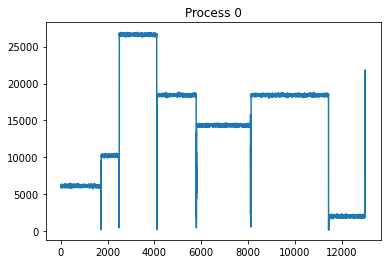

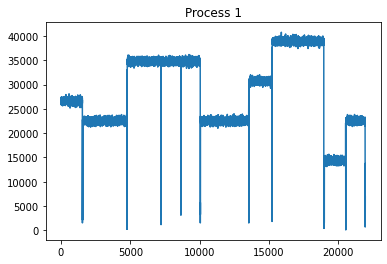

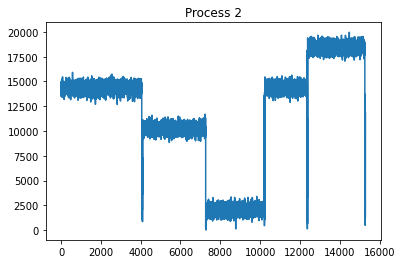

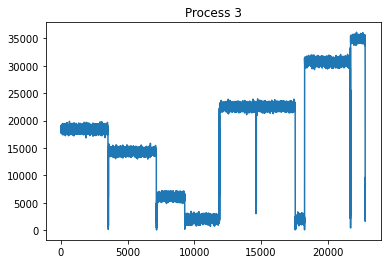

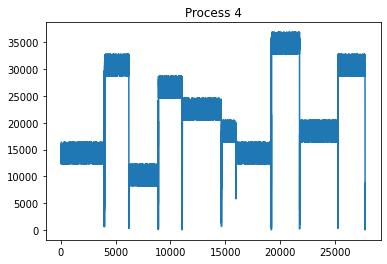

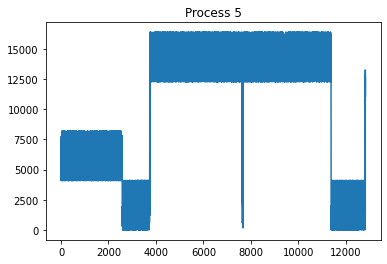

In [63]:
for i,p in enumerate(range(NP)) :
    fname = 'AR_' + '{:02d}'.format(p) + '.txt'
    data=np.loadtxt(fname)
    pl.plot(data)
    pl.title('Process {}'.format(i))
    pl.show()

In [64]:
init_phys_mem()

pr_que = init_proc_queue()

infiles = list()
outfiles = list()
for i in range(NP):
    fname = 'AR_{:02d}.txt'.format(i)
#     outname = 'AR_{:02}_{}_out.txt'.format(i, algo)

    if os.access(fname, os.R_OK):
        print(f'Reading Process from {fname}')
        infiles.append(open(fname, 'r'))
    else:
        print(f'Cannot open {fname} for reading')
#     outfiles.append(open(outname, 'w'))

# Map logical into physical addresses and keep track of page faults
for pr in readq(pr_que):
    rv = mem_manager(infiles[pr], pr)
    if rv == INVALID:
        print('Memory overflow error')
        break
    if rv == INCOMPLETE:
        pr_que.put_nowait(pr)
    else:
#             print(f'Process {pr} (Size: {pr_size[pr]} Bytes) completed; \
#             removing from queue')
#             print(f'Time taken: {pr_timing[pr]}')
#         slow = (pr_timing[pr] - pr_size[pr]) * 100.0 / pr_size[pr]
#         print('Slow down by {:.2f}%'.format(slow))
#         print_phys_mem()
        update_phys_mem(pr)

#        print('Current Status of Physical Memory')
#        print_phys_mem()

# Close all files
for i in range(NP):
    infiles[i].close()
#     outfiles[i].close()

[2, 4, 3, 0, 1, 5]
Reading Process from AR_00.txt
Reading Process from AR_01.txt
Reading Process from AR_02.txt
Reading Process from AR_03.txt
Reading Process from AR_04.txt
Reading Process from AR_05.txt
0
Memory overflow error


In [65]:
# fig,axes=pl.subplots(2,3,figsize=(15,10))
# axes=axes.ravel()[:5]
# for algo,axs in zip(algos,axes):
#     file_name='AR_00_{}_out.txt'.format(algo)
#     file=open(file_name,'r')
#     data=file.read()
#     datas=np.array(data.split('\n'))
#     faults=[data[-1] for data in datas[:-1]]
#     sns.countplot(x=faults,ax=axs)
#     axs.set_title(" {} {}".format(algo,collections.Counter(faults)))

In [66]:
lru_l=np.array(lru_l)
lru_g=np.array(lru_g)
fifo_l=np.array(fifo_l)
fifo_g=np.array(fifo_g)
mru_l=np.array(mru_l)
lfu_l=np.array(lfu_l)
rr_l=np.array(rr_l)
mru_g=np.array(mru_g)
lfu_g=np.array(lfu_g)
rr_g=np.array(rr_g)

In [67]:
lru_l=lru_l[lru_l[:,0]==0][:,1]
lru_g=lru_g[lru_g[:,0]==1][:,1]
fifo_l=fifo_l[fifo_l[:,0]==1][:,1]
fifo_g=fifo_g[fifo_g[:,0]==1][:,1]
lfu_l=lfu_l[lfu_l[:,0]==1][:,1]
mru_l=mru_l[mru_l[:,0]==1][:,1]
rr_l=rr_l[rr_l[:,0]==1][:,1]
lfu_g=lfu_g[lfu_g[:,0]==1][:,1]
mru_g=mru_g[mru_g[:,0]==1][:,1]
rr_g=rr_g[rr_g[:,0]==1][:,1]

ValueError: min() arg is an empty sequence

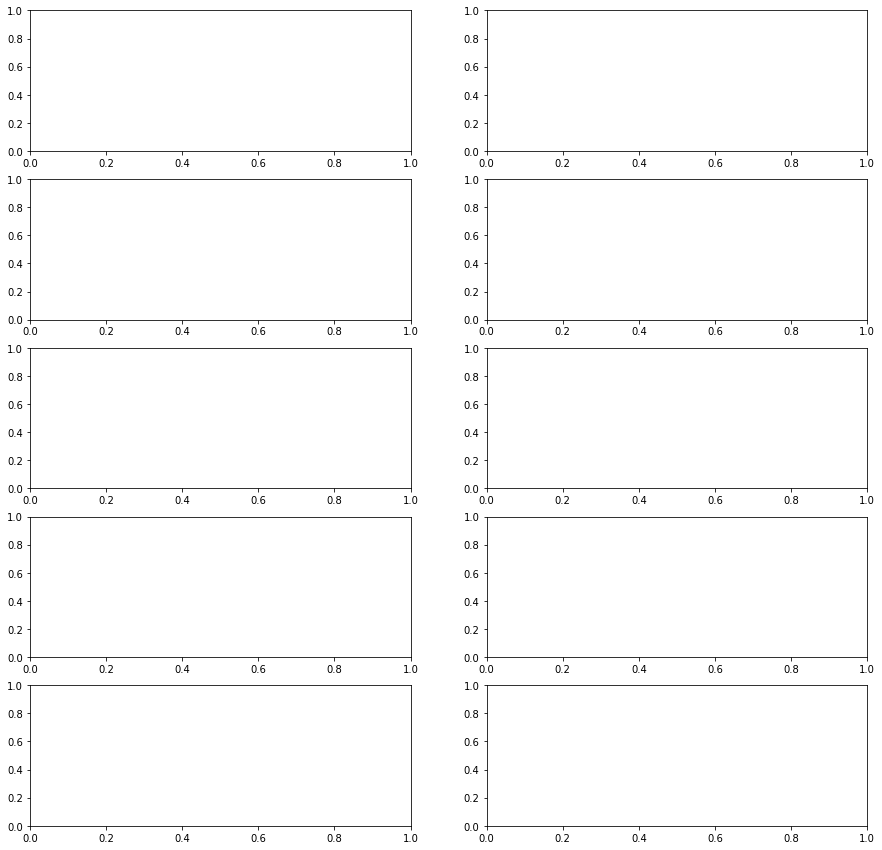

In [68]:
faults_list=[lru_l,lru_g,fifo_l,fifo_g,mru_l,mru_g,lfu_l,lfu_g,rr_l,rr_g]
fig,axes=pl.subplots(5,2,figsize=(15,15))
axes=axes.ravel()
for algo,fault,ax in zip(algos,faults_list,axes):
    sns.countplot(x=fault,ax=ax)
    ax.set_title(" {} {}".format(algo,collections.Counter(fault)))


In [ ]:
d=np.loadtxt('AR_02.txt')
pl.plot(d)